In [1]:
import scanpy as sc
import scvi
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
sc.set_figure_params(figsize=(4, 4))
import numpy as np
import torch
import matplotlib.pyplot as plt

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
adata = scvi.data.heart_cell_atlas_subsampled()
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [3]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def trainModel(adata,prior,max_epochs,freq=5,save=None, prior_kwargs=None):
    model = scvi.model.SCVI(adata,prior_distribution=prior, prior_kwargs=prior_kwargs,n_latent=2)
    model.train(max_epochs=max_epochs,check_val_every_n_epoch=freq)
    if save != None:
        model.save(save)
    return model

In [43]:
def plotPosterior(adata, vae,num=500):
    data = torch.tensor(adata.X[0:num].todense())
    data = data.to(torch.device('cuda:0'))
    distrs, zs = vae.module.z_encoder(data)
    d = np.transpose(np.array(zs.detach().cpu()))
    plt.scatter(d[0],d[1])

def contourPlotDist(dist, xlim, ylim):
    x = np.linspace(-xlim, xlim, 100)
    y = np.linspace(-ylim, ylim, 100)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            Z[i][j] = dist.log_prob(torch.tensor([x[i],y[j]]).to(torch.device('cuda:0')))
    plt.contour(X,Y,Z)

def posteriorVisualization(adata, vae, dist, lim, pr):
    plotPosterior(adata, vae)
    contourPlotDist(dist, lim, lim)
    plt.title("Posterior and Prior Vis " + pr + " Prior")
    plt.show()

def plotSamples(distr, num, title, numsamples = True):
    x = []; y = []
    for i in range(num):
        if numsamples:
            s = distr.sample(1).cpu()
            x.append(s[0,0])
            y.append(s[0,1])
        else:
            s = distr.sample()
            x.append(s[0])
            y.append(s[1])
    plt.scatter(x,y)
    plt.title(title)    

In [5]:
vaeSN = trainModel(adata,"sdnormal",100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [01:35<00:00,  1.04it/s, v_num=1, train_loss_step=310, train_loss_epoch=290]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:35<00:00,  1.04it/s, v_num=1, train_loss_step=310, train_loss_epoch=290]


In [6]:
vaeN = trainModel(adata, "normal", 100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [01:36<00:00,  1.05it/s, v_num=1, train_loss_step=337, train_loss_epoch=289]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s, v_num=1, train_loss_step=337, train_loss_epoch=289]


In [7]:
vaeMG = trainModel(adata, "mixofgaus", 100, prior_kwargs={"k":3})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it, v_num=1, train_loss_step=268, train_loss_epoch=290]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it, v_num=1, train_loss_step=268, train_loss_epoch=290]


In [9]:
vaeVP = trainModel(adata, "vamp", 100,prior_kwargs={"n_components":5})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:09<00:00,  1.37s/it, v_num=1, train_loss_step=341, train_loss_epoch=291]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it, v_num=1, train_loss_step=341, train_loss_epoch=291]


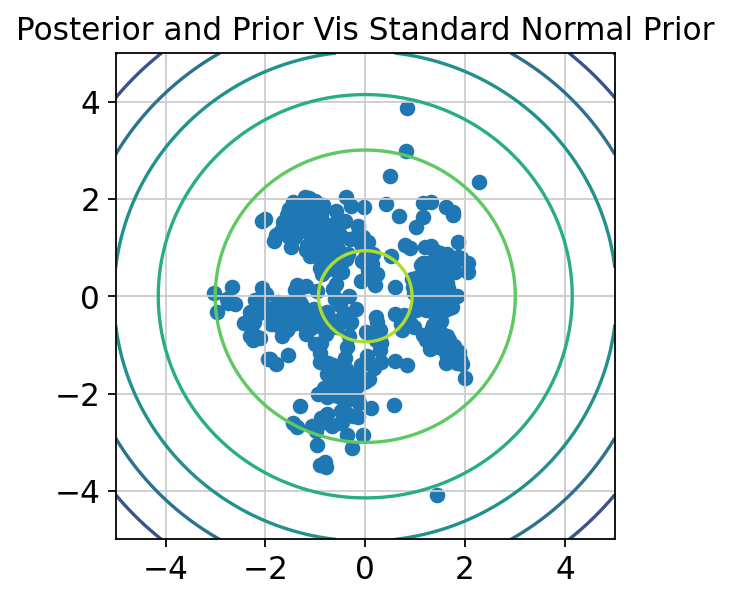

Text(0.5, 1.0, 'Posterior and Prior Samples Stadard Normal Prior')

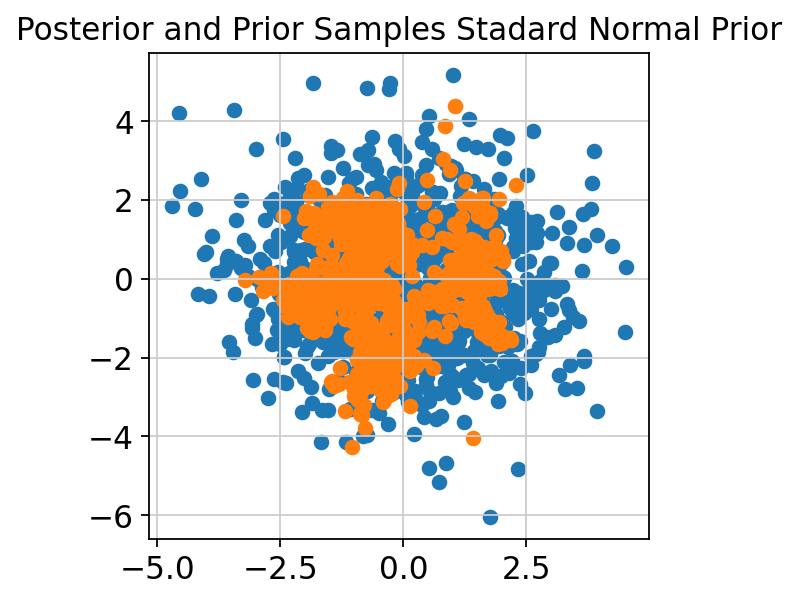

In [44]:
posteriorVisualization(adata, vaeSN, vaeSN.module.prior,5,"Standard Normal")
plotSamples(vaeSN.module.prior,num=1000,title="")
plotPosterior(adata,vaeSN,num=1000)
plt.title("Posterior and Prior Samples Standard Normal Prior")

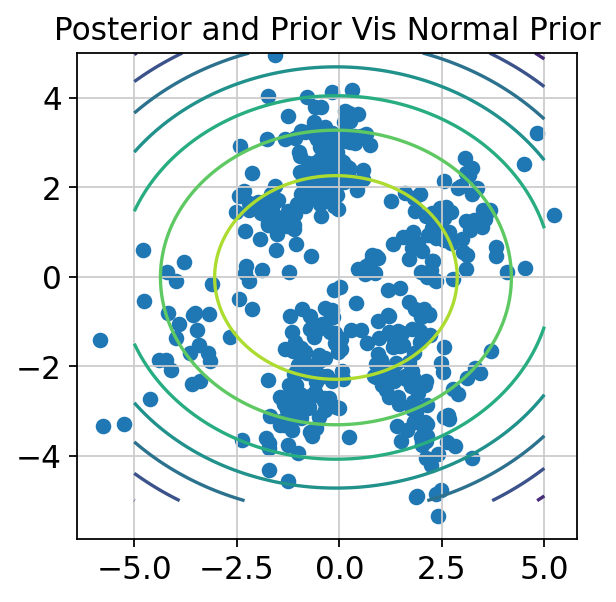

Text(0.5, 1.0, 'Posterior and Prior Samples Normal Prior')

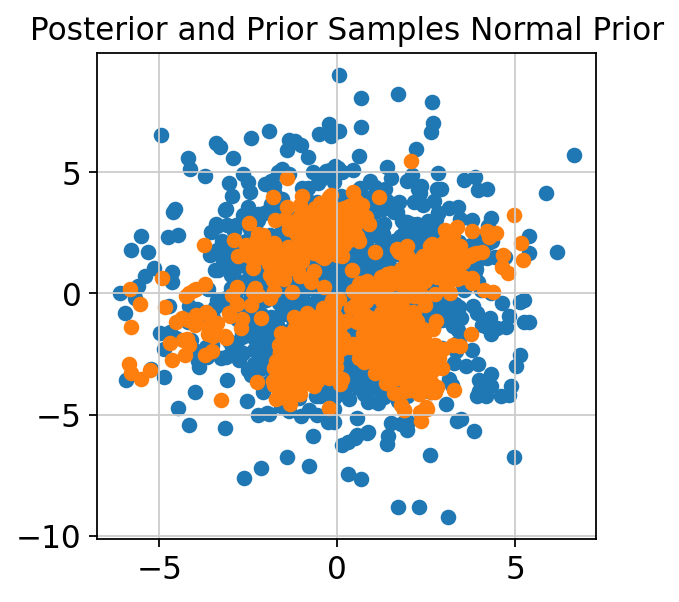

In [45]:
posteriorVisualization(adata, vaeN, vaeN.module.prior,5,"Normal")
plotSamples(vaeN.module.prior,num=1000,title="")
plotPosterior(adata,vaeN,num=1000)
plt.title("Posterior and Prior Samples Normal Prior")

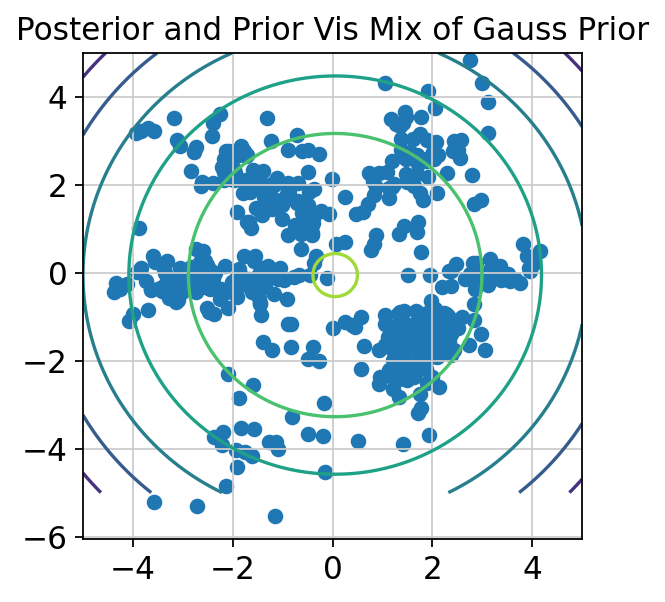

Text(0.5, 1.0, 'Posterior and Prior Samples Mix of Gauss Prior')

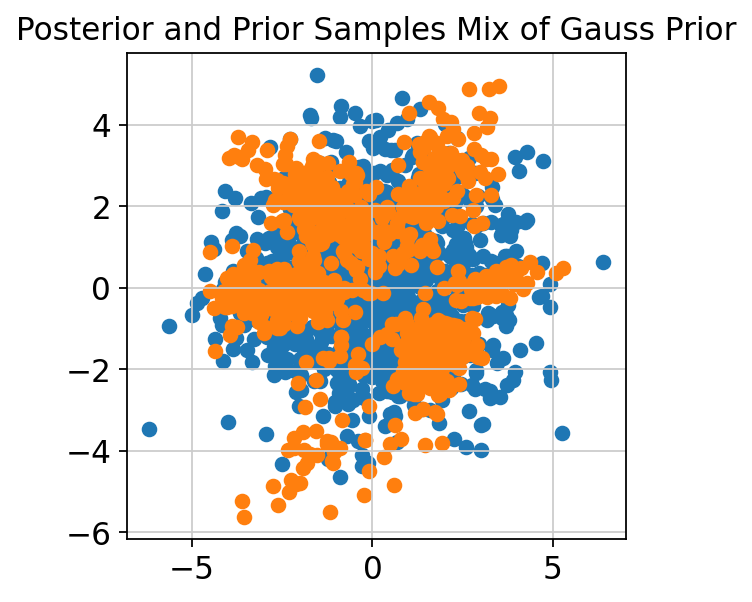

In [46]:
posteriorVisualization(adata, vaeMG, vaeMG.module.prior,5,"Mix of Gauss")
plotSamples(vaeMG.module.prior,num=1000,title="")
plotPosterior(adata,vaeMG,num=1000)
plt.title("Posterior and Prior Samples Mix of Gauss Prior")

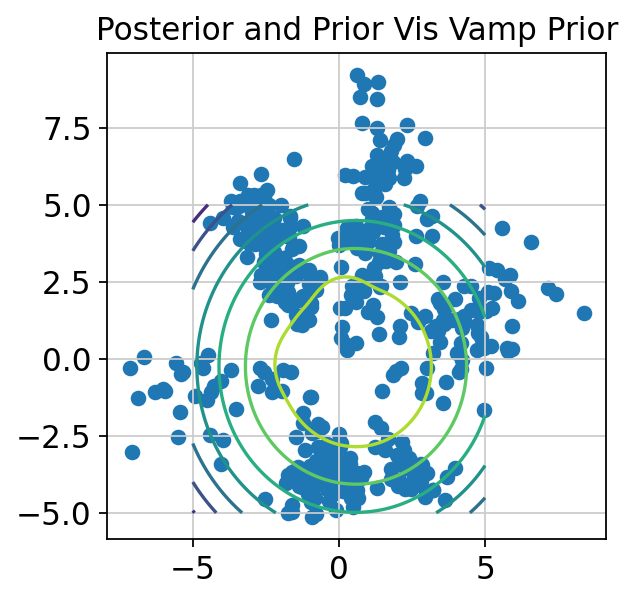

Text(0.5, 1.0, 'Posterior and Prior Samples Vamp Prior')

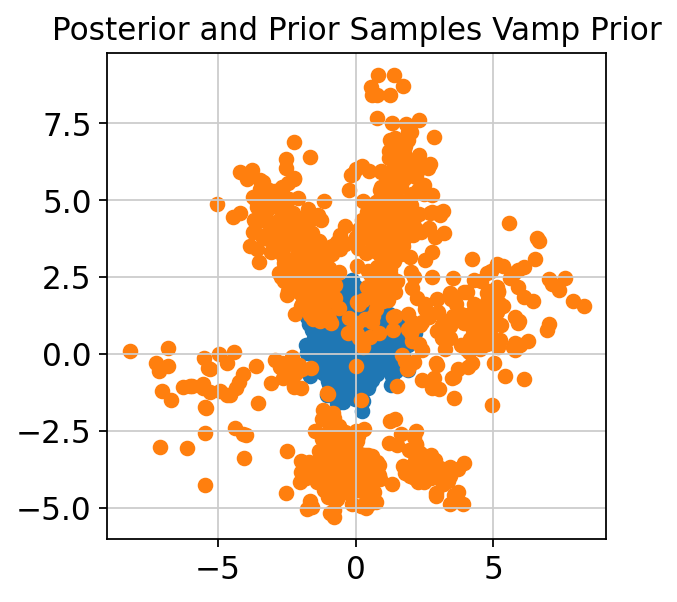

In [47]:
posteriorVisualization(adata, vaeVP, vaeVP.module.prior,5,"Vamp")
plotSamples(vaeVP.module.prior,num=1000,title="")
plotPosterior(adata,vaeVP,num=1000)
plt.title("Posterior and Prior Samples Vamp Prior")